# AOS_PS1_ROTANG_inspect


Simulate a high-latitude field introducing 30 degree rotation

    ssh scichris@lsst-login01.ncsa.illinois.edu 
    ssh lsst-devl03  / lsst-devl01 
    
    source "/software/lsstsw/stack/loadLSST.bash"
    setup lsst_distrib
    setup -k -r /project/scichris/aos/phosim_utils/
    
    
    python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/ps1_phosim/test_rotang/stars_comCam_PS1_high_focal_rotskypos_30.inst -i comcam -e 1 -c /project/scichris/aos/ps1_phosim/noBkgnd.cmd -p 24 -w /project/scichris/aos/ps1_phosim/test_rotang/rotskypos -s R22_S01 -o /project/scichris/aos/ps1_phosim/test_rotang/rotskypos/raw > /project/scichris/aos/ps1_phosim/test_rotang/rotskypos/starPhoSim.log 2>&1

## 1) repackage with phosim_utils `master`

Repackage on phosim_utils `master`, where 


    ROTANG = 90 - PHOSIM_ROTANG 

    phosim_repackager.py /project/scichris/aos/ps1_phosim/test_rotang/rotskypos/raw     --out_dir /project/scichris/aos/ps1_phosim/test_rotang/rotskypos/repackaged2 --inst comcam

Ingest and run the ISR ...

    ./runIsr2.sh

    ingest INFO: Successfully extracted metadata from 1 file with 0 failures
    ingest INFO: Exposure LSSTComCam:CC_H_20211231_006002 ingested successfully
    ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
    ingest INFO: Ingested 1 distinct Butler dataset
    defineVisits INFO: Preprocessing data IDs.
    defineVisits INFO: Registering visit_system 1: by-group-metadata.
    defineVisits INFO: Grouping 1 exposure(s) into visits.
    defineVisits INFO: Computing regions and other metadata for 1 visit(s).
    ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 1 quanta for 1 tasks, graph ID: '1621448295.036854-9592'
    conda.common.io INFO: overtaking stderr and stdout
    conda.common.io INFO: stderr and stdout yielding back
    isr INFO: Converting exposure to floating point values.
    isr INFO: Assembling CCD from amplifiers.
    isr INFO: Widening saturation trails.
    isr INFO: Applying gain correction instead of flat.
    isr WARN: No rough magnitude zero point set for filter FilterLabel(band="r", physical="r_03").
    isr INFO: Setting rough magnitude zero point: 28.000000
    ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'isr' on quantum {instrument: 'LSSTComCam', detector: 1, exposure: 4021123106002, ...} took 5.480 seconds
    ctrl.mpexec.mpGraphExecutor INFO: Executed 1 quanta successfully, 0 failed and 0 remain out of total 1 quanta.

In [2]:
import numpy as np
import os
import pandas as pd
from lsst.daf import butler as dafButler
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

%matplotlib inline

def plot_postIsr(repo_dir='/project/scichris/aos/ps1_phosim/test_rotang/rotskypos/DATA2/',title='master'):

    instrument = 'LSSTComCam'
    inst_file = '/project/scichris/aos/ps1_phosim/test_rotang/stars_comCam_PS1_high_focal_rotskypos_30.inst'
    detector = 'R22_S01'

    print(f'Using {repo_dir}')
    butler = dafButler.Butler(repo_dir, collections=[f'{instrument}/raw/all',
                                                     f'{instrument}/calib','run1',
                                                     f'{instrument}/calib/unbounded']
                             )
    # this is just to get the exposure  number
    # so that we don't have  to guess...
    dataId0 = dict(instrument=instrument)
    dataset = next(iter(
                        butler.registry.queryDatasets(
                            datasetType='postISRCCD', 
                            collections=['run1'],
                            dataId=dataId0  )
                        )
                   )
    exp_num = dataset.dataId["exposure"]


    exposure = butler.get('postISRCCD', detector=detector, instrument=instrument,
              exposure=exp_num,collections=['run1'])



    # read in the input instance catalog 
    cat = np.genfromtxt(inst_file, skip_header=16)

    cat_df = pd.DataFrame(cat[:, 1:5], columns=['id', 'ra', 'dec', 'g'])

    #########################
    # Use the original WCS 
    #########################

    # get the wcs 
    wcs = exposure.getWcs()

    # calculate the position given the x,y 
    x,y = wcs.skyToPixelArray(cat_df['ra'], cat_df['dec'],degrees=True)    


    # plot the WCS-inferred stellar position on top of the data 
    data = exposure.image.array
    vmin, vmax = zscale.get_limits(data)

    fig = plt.figure(figsize=(10,10))
    plt.imshow(data, vmin=vmin,vmax=vmax,cmap='Greys')
    plt.scatter(x,y,  facecolors='none', edgecolors='r', marker='o',s=50, )
    plt.xlim(0, 4000)
    plt.ylim(0, 4000)
    plt.title(f"lsstComCam {exposure.getDetector().getName()} {title} ")
    plt.xlabel('x [px]')
    plt.ylabel('y [px]')



Using /project/scichris/aos/ps1_phosim/test_rotang/rotskypos/DATA2/


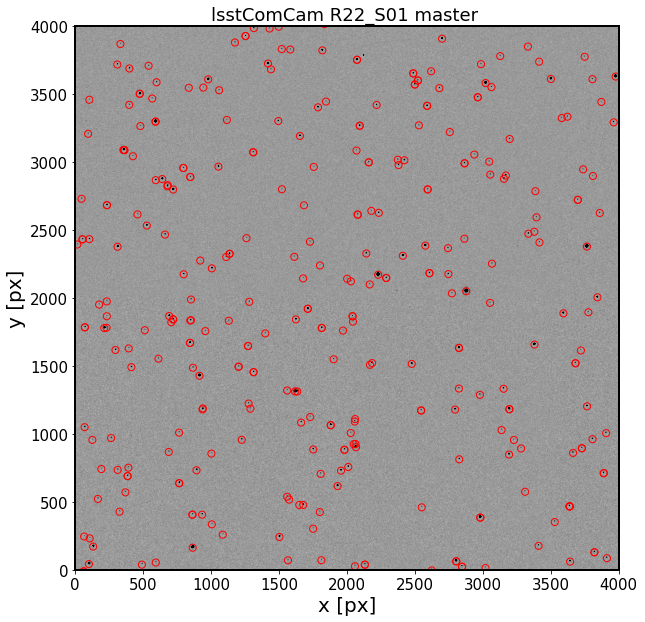

In [3]:
plot_postIsr(repo_dir='/project/scichris/aos/ps1_phosim/test_rotang/rotskypos/DATA2/',title='master')

Thus correct WCS is attached to the exposure

## 2) Repackage with `phosim_utils` on `tickets/DM-30128` (Tiago's branch)

Repackage on `phosim_utils` tickets/DM-30128, where

    ROTANG = PHOSIM_ROTANG 
    phosim_repackager.py /project/scichris/aos/ps1_phosim/test_rotang/rotskypos/raw     --out_dir /project/scichris/aos/ps1_phosim/test_rotang/rotskypos/repackaged3 --inst comcam


    Ingest and run the ISR ...
    
    ./runIsr3.sh
    
        ingest INFO: Successfully extracted metadata from 1 file with 0 failures
    ingest INFO: Exposure LSSTComCam:CC_H_20211231_006002 ingested successfully
    ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
    ingest INFO: Ingested 1 distinct Butler dataset
    defineVisits INFO: Preprocessing data IDs.
    defineVisits INFO: Registering visit_system 1: by-group-metadata.
    defineVisits INFO: Grouping 1 exposure(s) into visits.
    defineVisits INFO: Computing regions and other metadata for 1 visit(s).
    Traceback (most recent call last):
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.6.0/Linux64/daf_butler/21.0.0-88-g6c5b53fb+7b9a448d34/bin/butler", line 28, in <module>
        sys.exit(main())
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.6.0/Linux64/daf_butler/21.0.0-88-g6c5b53fb+7b9a448d34/python/lsst/daf/butler/cli/butler.py", line 321, in main
        return cli()
      File "/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.6.0/lib/python3.8/site-packages/click/core.py", line 829, in __call__
        return self.main(*args, **kwargs)
      File "/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.6.0/lib/python3.8/site-packages/click/core.py", line 782, in main
        rv = self.invoke(ctx)
      File "/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.6.0/lib/python3.8/site-packages/click/core.py", line 1259, in invoke
        return _process_result(sub_ctx.command.invoke(sub_ctx))
      File "/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.6.0/lib/python3.8/site-packages/click/core.py", line 1066, in invoke
        return ctx.invoke(self.callback, **ctx.params)
      File "/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.6.0/lib/python3.8/site-packages/click/core.py", line 610, in invoke
        return callback(*args, **kwargs)
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.6.0/Linux64/obs_base/21.0.0-53-g60776b0+56e2f390b0/python/lsst/obs/base/cli/cmd/commands.py", line 94, in define_visits
        script.defineVisits(*args, **kwargs)
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.6.0/Linux64/obs_base/21.0.0-53-g60776b0+56e2f390b0/python/lsst/obs/base/script/defineVisits.py", line 61, in defineVisits
        task.run(butler.registry.queryDataIds(["exposure"], dataId={"instrument": instr.getName()}),
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.6.0/Linux64/obs_base/21.0.0-53-g60776b0+56e2f390b0/python/lsst/obs/base/defineVisits.py", line 550, in run
        for visitRecords in self.progress.wrap(allRecords, total=len(definitions),
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.6.0/Linux64/daf_butler/21.0.0-88-g6c5b53fb+7b9a448d34/python/lsst/daf/butler/core/progress.py", line 246, in wrap
        yield from bar
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.6.0/Linux64/obs_base/21.0.0-53-g60776b0+56e2f390b0/python/lsst/obs/base/defineVisits.py", line 469, in _buildVisitRecordsSingle
        return self._buildVisitRecords(args[0], collections=args[1])
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.6.0/Linux64/obs_base/21.0.0-53-g60776b0+56e2f390b0/python/lsst/obs/base/defineVisits.py", line 363, in _buildVisitRecords
        visitRegion, visitDetectorRegions = self.computeVisitRegions.compute(definition,
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.6.0/Linux64/obs_base/21.0.0-53-g60776b0+56e2f390b0/python/lsst/obs/base/defineVisits.py", line 789, in compute
        detectorBounds = self.computeExposureBounds(visit.exposures[0], collections=collections)
      File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.6.0/Linux64/obs_base/21.0.0-53-g60776b0+56e2f390b0/python/lsst/obs/base/defineVisits.py", line 736, in computeExposureBounds
        orientation = lsst.geom.Angle(exposure.sky_angle, lsst.geom.degrees)
    TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
        1. lsst.geom.Angle(val: float, units: lsst.geom.AngleUnit = <lsst.geom.AngleUnit object at 0x7f1c04f42d70>)
        2. lsst.geom.Angle()

    Invoked with: None, <lsst.geom.AngleUnit object at 0x7f1bda490230>
    ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 1 quanta for 1 tasks, graph ID: '1621447794.0424514-9082'
    conda.common.io INFO: overtaking stderr and stdout
    conda.common.io INFO: stderr and stdout yielding back
    isr INFO: Converting exposure to floating point values.
    isr INFO: Assembling CCD from amplifiers.
    isr INFO: Widening saturation trails.
    isr INFO: Applying gain correction instead of flat.
    isr WARN: No rough magnitude zero point set for filter FilterLabel(band="r", physical="r_03").
    isr INFO: Setting rough magnitude zero point: 28.000000
    ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'isr' on quantum {instrument: 'LSSTComCam', detector: 1, exposure: 4021123106002, ...} took 5.310 seconds
    ctrl.mpexec.mpGraphExecutor INFO: Executed 1 quanta successfully, 0 failed and 0 remain out of total 1 quanta.

Using /project/scichris/aos/ps1_phosim/test_rotang/rotskypos/DATA3/


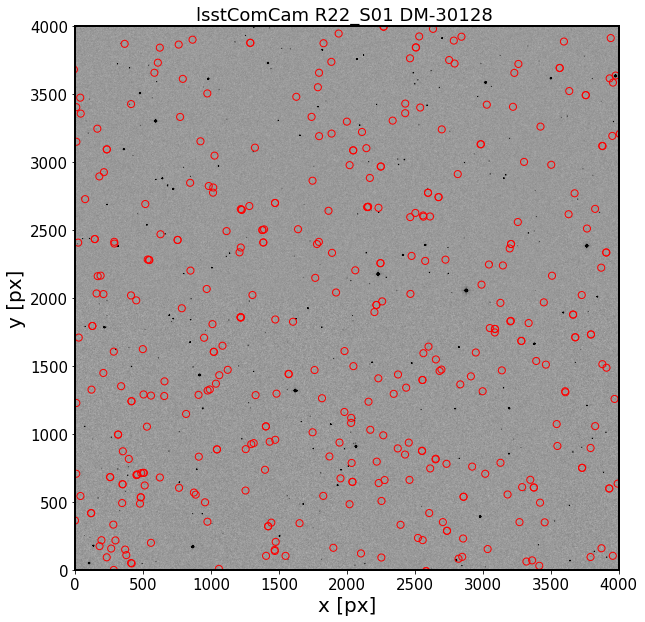

In [4]:
plot_postIsr(repo_dir='/project/scichris/aos/ps1_phosim/test_rotang/rotskypos/DATA3/',title='DM-30128')

The attached WCS is now incorrect. 